# Step 2: Generate Simulated Data

Load relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint, getrandbits
import os
from scipy import ndimage, misc

%matplotlib inline

Image generator function

In [2]:
#Function to create an image. Already randomises parameters.

def one_d_to_two_d(signal_type):
    
    # type: line, curve, chopped line, chopped curve, wibble, splodge, bright pixel
    
    #Create 2D noise data
    n_points=16       #how many points in the signal?
    lower=0           #lower limit of new range
    upper=48          #upper limit of new range
    sig_strength=2    #signal strength
    offset=0          #offset in x-direction from origin
    flip=False        #flip the signal?
    gradient=1        #gradient of signal where relevant
    chop=False        #chop the signal up?
    gap_size=2        #gap size if chopped
    signal_length=5   #signal length if chopped
    #transpose=False  #transpose the incoming data?
    ghost=False       #create 'ghosts' of the signal?
    ghost_size=5      #ghost offset left and right
    ghost_division=2  #ghost signal strength division
    noise_floor=0     #lower limit of noise
    noise_ceiling=0.1  #upper limit of noise
    n_width = 256#273#706 #Number of pixels along x-axis
    repeats = 273#819#15 #How many repeats of *the same* random signal (don't just want 1 pixel)
    n_repeats = 16 #How many repeats of *different* random signals

    sig_all = np.empty((0))

    for n in range(0,n_repeats):
        random = np.random.normal(noise_floor,noise_ceiling,n_width)
        sig = np.repeat(random, repeats=repeats, axis=0)
        sig_reshaped = np.reshape(sig, newshape=(-1, repeats))
        sig_reshaped = np.transpose(sig_reshaped)

        if sig_all.shape == (0,):
            sig_all = sig_reshaped
        else:
            sig_all = np.concatenate((sig_all, sig_reshaped), axis=0)
       
    
    def rebin(a, shape):
        sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
        return a.reshape(sh).mean(-1).mean(1)
  
    #new_shape = rebin(sig_all,(16,706))
    new_shape = rebin(sig_all,(repeats,n_width))
    two_d = new_shape
     
    
    
    #Create signal data   
    
    if signal_type == 'line':
        
        sig_strength = noise_ceiling + np.random.uniform(1,20)
        offset = np.random.randint(0, 200) 
        flip = bool(getrandbits(1))
        gradient = np.random.randint(1, 10)
        #ghost = bool(getrandbits(1))
        ghost = False
        ghost_size = np.random.randint(5, 20)
        ghost_division = np.random.randint(2, 5)
        
        N_points = 16
        data_1d = np.linspace(0, N_points, 70)
        
        dt_scaled = data_1d
        dt_scaled = dt_scaled * gradient
                
      
        
    if signal_type == 'chopped_line':
        
        N_points = 16
        data_1d = np.linspace(0, N_points, 70)
        
        sig_strength = noise_ceiling + np.random.uniform(1,20)
        offset = np.random.randint(0, 200) 
        flip = bool(getrandbits(1))
        gradient = np.random.randint(1, 5)
        #ghost = bool(getrandbits(1))
        ghost = False
        ghost_size = np.random.randint(5, 20)
        ghost_division = np.random.randint(2, 5)
        chop=True
        gap_size = np.random.randint(2, 4)
        signal_length = np.random.randint(2, 5)
        
        dt_scaled = data_1d
        dt_scaled = dt_scaled * gradient
        
  
    
    if signal_type == 'curve':
        
        N_points = 16
        data_1d = np.linspace(0, N_points, 70)
        power_choice = np.random.randint(2, size=1)+2
        data_1d = np.power(data_1d, power_choice)
        
        sig_strength = noise_ceiling + np.random.uniform(1,20)
        offset = np.random.randint(0, 200) 
        flip = bool(getrandbits(1))
        gradient = np.random.randint(1, 10)
        #ghost = bool(getrandbits(1))
        ghost = False
        ghost_size = np.random.randint(5, 20)
        ghost_division = np.random.randint(2, 5)
        
        dt_scaled = data_1d
        #dt_scaled = dt_scaled * gradient
    
      
        
    if signal_type == 'wibble':
        
        def geometric_brownian_motion(T = 0.001, N = 2, mu = 1, sigma = 0.1, S0 = 1):        
            dt = float(T)/N
            t = np.linspace(0, T, N)
            W = np.random.standard_normal(size = N) 
            W = np.cumsum(W)*np.sqrt(dt) ### standard brownian motion ###
            X = (mu-0.5*sigma**2)*t + sigma*W 
            S = S0*np.exp(X) ### geometric brownian motion ###
            return S

        N_points = 16
        data_1d = geometric_brownian_motion(T = 0.1, N = N_points, mu = 1, sigma = 5, S0 = 100)
        
        sig_strength = noise_ceiling + np.random.uniform(1,20)
        offset = np.random.randint(0, 200) 
        flip = bool(getrandbits(1))
        gradient = np.random.randint(1, 5)
        #ghost = bool(getrandbits(1))
        ghost = False
        ghost_size = np.random.randint(5, 20)
        ghost_division = np.random.randint(2, 5)
        
        #This bit takes the limited number of points, stretches them out, fills in the gaps and scales to suitable ranges,
        dt_scaled = np.interp(data_1d, (data_1d.min(), data_1d.max()), (lower, upper))
        xvals = np.linspace(0, n_points, upper) #create the new x-axis. The last parameter is the number of new points
        xvals = xvals * gradient
        f = np.arange(0,n_points,1)
        yinterp = np.interp(xvals, f, dt_scaled)
        dt_scaled = yinterp
        
        
           
    n = n_points / (gap_size + signal_length)
    i=0
    
    if (chop == True and signal_type != 'brightpixel' and signal_type != 'noise'):
        while i<n:
            dt_scaled[(i*gap_size+i*signal_length):((i+1)*gap_size+i*signal_length)] = 0
            i=i+1
    
    if (signal_type != 'brightpixel' and signal_type != 'noise'):
    
        for n in range(0, len(dt_scaled), 1):
            dt_scaled[n] = (round(dt_scaled[n],9))
        dt_scaled = dt_scaled.astype(int)

        #Create the signal
        for i in range(0, max(dt_scaled)-1, 1):
            try:
                if dt_scaled[i] == 0:
                    two_d[dt_scaled[i]+offset,i] = np.random.normal(lower_intensity,upper_intensity,1)
                else:
                    two_d[i,dt_scaled[i]+offset] = sig_strength
                    two_d[i,dt_scaled[i]+offset+1] = sig_strength
                    two_d[i,dt_scaled[i]+offset-1] = sig_strength
                    two_d[i,dt_scaled[i]+offset+2] = sig_strength
                    two_d[i,dt_scaled[i]+offset-2] = sig_strength
                    #two_d[i,dt_scaled[i]+offset+3] = sig_strength
                    #two_d[i,dt_scaled[i]+offset-3] = sig_strength

            except:
                IndexError
            continue
                       
            
    if (ghost == True and signal_type != 'brightpixel' and signal_type != 'noise'):
        for i in range(0, max(dt_scaled)-1, 1):
            try:
                if dt_scaled[i] == 0:
                    two_d[dt_scaled[i]+offset,i] = np.random.normal(lower_intensity,upper_intensity,1)
                else:
                    two_d[i,dt_scaled[i]+offset+1+ghost_size] = sig_strength/ghost_division
                    two_d[i,dt_scaled[i]+offset-1-ghost_size] = sig_strength/ghost_division
                    two_d[i,dt_scaled[i]+offset+2+ghost_size] = sig_strength/ghost_division
                    two_d[i,dt_scaled[i]+offset-2-ghost_size] = sig_strength/ghost_division
                    two_d[i,dt_scaled[i]+offset+3+ghost_size] = sig_strength/ghost_division
                    two_d[i,dt_scaled[i]+offset-3-ghost_size] = sig_strength/ghost_division

            except:
                IndexError
            continue
                    
           
    if flip == True:
        two_d = np.fliplr(two_d)
   
    
    if signal_type == 'brightpixel':
        
        rand_x = np.random.randint(two_d.shape[0],size=1)
        rand_y = np.random.randint(two_d.shape[1],size=1)
        
        sig_strength= np.random.randint(400, size=1)+50
        two_d[rand_x, rand_y] = sig_strength

    #return(two_d.transpose())
    #pongo esto para que lo devuelva ya normalizado
    two_d = (two_d - np.mean(two_d))/np.std(two_d)
    return(two_d)

Check examples of each

## Line

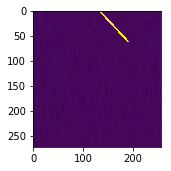

In [3]:
line = one_d_to_two_d(signal_type='line')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
#line = (line - np.mean(line))/np.std(line)
ax.imshow(line
          #,extent=(0, 819, 240, 0)
          #,cmap='nipy_spectral'
         )
#ax.set_aspect('auto')

In [4]:
line.shape

(273, 256)

## Wibble

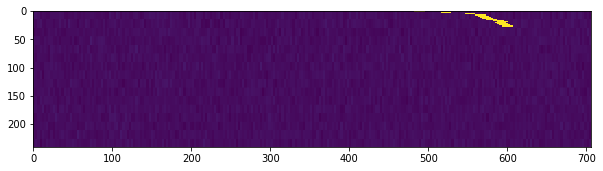

In [5]:
wibble = one_d_to_two_d(signal_type='wibble')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.imshow(wibble, 
          rasterized=False,
          interpolation='nearest',
          extent=(0, 706, 240, 0),
          cmap='viridis',)
ax.set_aspect('auto')

In [6]:
wibble.shape

(273, 256)

## Chopped line

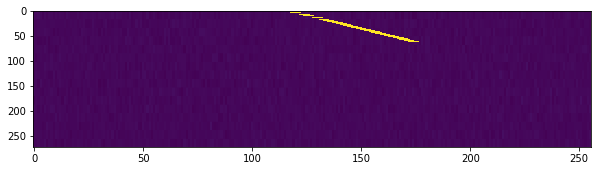

In [7]:
chopped_line = one_d_to_two_d(signal_type='chopped_line')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.imshow(chopped_line,
          #extent=(0, 706, 240, 0),
          #cmap='viridis',
         )
ax.set_aspect('auto')

In [8]:
chopped_line.shape

(273, 256)

## Curve

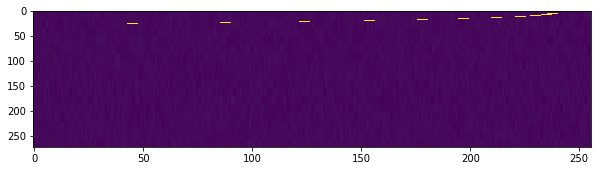

In [9]:
curve = one_d_to_two_d(signal_type='curve')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.imshow(curve,
          #extent=(0, 706, 240, 0),
          #cmap='viridis',
         )
ax.set_aspect('auto')

In [10]:
curve.shape

(273, 256)

## Brightpixel

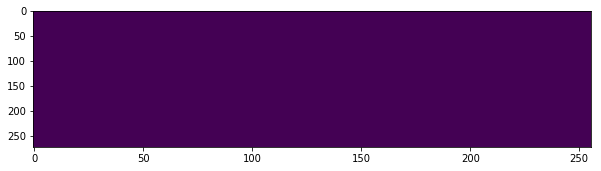

In [11]:
brightpixel = one_d_to_two_d(signal_type='brightpixel')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.imshow(brightpixel,
          #extent=(0, 706, 240, 0),
          #cmap='viridis',
         )
ax.set_aspect('auto')

In [12]:
brightpixel.shape

(273, 256)

## Noise

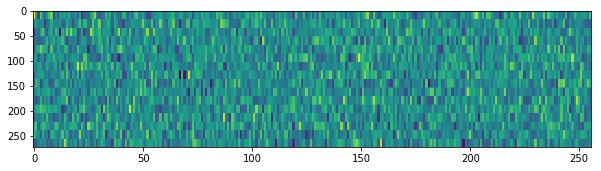

In [13]:
noise = one_d_to_two_d(signal_type='noise')

fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(111)
ax.imshow(noise,
          #extent=(0, 706, 240, 0),
          #cmap='viridis',
         )
ax.set_aspect('auto')

In [14]:
noise.shape

(273, 256)

Grid de imagenes

Text(0.5,1,'noise')

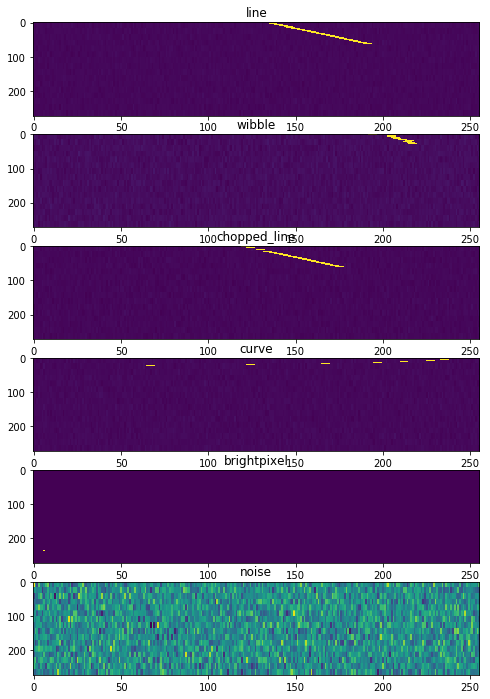

In [15]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4, ax5 ,ax6) = plt.subplots(6,1,figsize=(8,12))
ax1.imshow(line, interpolation='nearest', aspect='auto')
ax1.set_title('line')
ax2.imshow(wibble, interpolation='nearest', aspect='auto')
ax2.set_title('wibble')
ax3.imshow(chopped_line, interpolation='nearest', aspect='auto')
ax3.set_title('chopped_line')
ax4.imshow(curve, interpolation='nearest', aspect='auto')
ax4.set_title('curve')
ax5.imshow(brightpixel, interpolation='nearest', aspect='auto')
ax5.set_title('brightpixel')
ax6.imshow(noise, interpolation='nearest', aspect='auto')
ax6.set_title('noise')

#plt.savefig('simulated_singal.jpg')

In [16]:
def plotCadence(img):
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        plt.imshow(img[i], interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
    plt.show()

In [17]:
def random_channel_signal (img):
    canal = np.random.choice([0,2,4])
    minimo = img[canal].min()
    for i in range(img.shape[0]):
        img[i] -= img[i].mean()
        img[i] /= img[i].std()
    tipo = np.random.choice(['line','wibble','chopped_line','curve','brightpixel'])
    signal = one_d_to_two_d(tipo)
    signal = np.clip(signal, minimo, 20)
    result = (imagen[canal]*0.7 + signal*0.3)/2
    result = (result - np.mean(result))/np.std(result)
    img[canal] = result
    return img

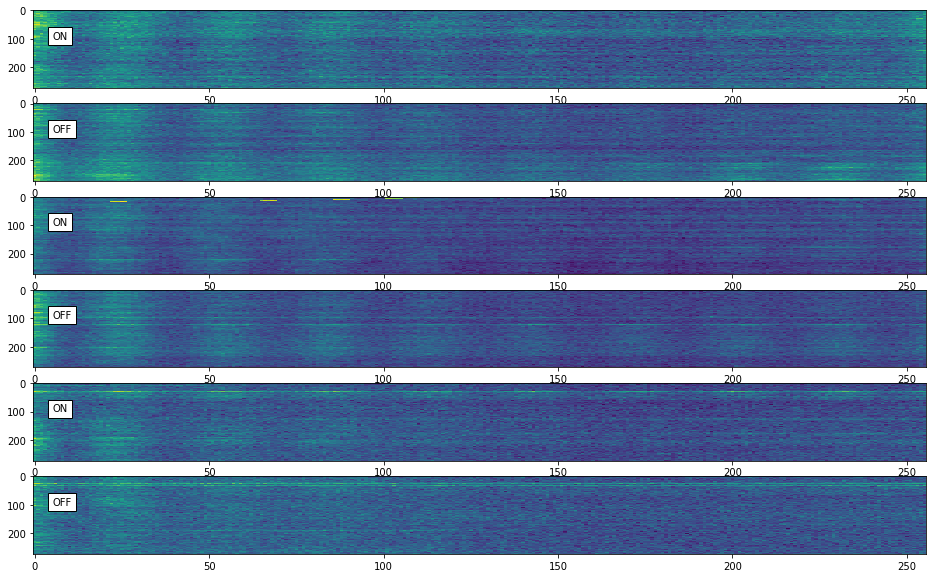

In [18]:
imagen = np.load('../input/seti-breakthrough-listen/train/0/0000799a2b2c42d.npy').astype(np.float32)
resultado = random_channel_signal(imagen)

plotCadence(resultado)

# Generamos 10000 imagenes con señales aleatorias y las guardamos 

In [19]:
import pandas as pd
import numpy as np
import os
import glob

np.random.seed(12)

In [20]:
#Cogemos las imagenes reales de SETI competition

PATH = '../input/seti-breakthrough-listen/'

df_labels = pd.concat([
    pd.read_csv(PATH + 'train_labels.csv'),
    # pd.read_csv(PATH + 'old_leaky_data/train_labels_old.csv'),
    # pd.read_csv(PATH + 'old_leaky_data/test_labels_old.csv'),
]).reset_index(drop=True)


df_sample_sub = pd.read_csv(PATH + 'sample_submission.csv')
print(df_labels['target'].value_counts()/len(df_labels))

list_paths_train = glob.glob(PATH + 'train/' + '*/*.npy')# + glob.glob(PATH + 'old_leaky_data/train_old/' + '*/*.npy') + glob.glob(PATH + 'old_leaky_data/test_old/' + '*/*.npy')
list_paths_test = glob.glob(PATH + 'test/' + '*/*.npy')

print(f'{len(list_paths_train)} train paths, {len(list_paths_test)} test paths')


dict_paths_train = {path.split('/')[-1].split('.npy')[0] : path for path in list_paths_train}
dict_paths_test = {path.split('/')[-1].split('.npy')[0] : path for path in list_paths_test}

df_labels['path'] = df_labels['id'].apply(lambda x : dict_paths_train[x])
df_sample_sub['path'] = df_sample_sub['id'].apply(lambda x : dict_paths_test[x])

list_records = df_labels[['id', 'target']].to_dict('records')
dict_paths_labels_train = {elem['id'] : elem['target'] for elem in list_records}

IMG_SIZE = (340, 340, 3)

pos, neg = len(df_labels[df_labels['target']==1]), len(df_labels[df_labels['target']==0])

assert df_sample_sub.isna().sum().sum() == 0
assert df_labels.isna().sum().sum() == 0


0    0.9
1    0.1
Name: target, dtype: float64
60000 train paths, 39995 test paths


In [21]:
from random import sample

n = 5000 #numero de muestras a extraer

In [22]:
#creamos el directorio
if not os.path.exists('sintetic_images'):
    os.makedirs('sintetic_images')

In [23]:
index = df_labels.index
condition = df_labels["target"] == 0
no_signal_indices = index[condition]
no_signal_indices_list = no_signal_indices. tolist()
random_choice = sample(no_signal_indices_list,n)

df_sintetic = df_labels.loc[random_choice]
df_sintetic.target = df_sintetic.target+1
#df_sintetic

In [24]:
for i in range(n):
    '''j= i//500
    if not os.path.exists('./sintetic_images/'+str(j)):
        os.makedirs('./sintetic_images/'+str(j))'''

    INDEX = random_choice[i]
    imagen = np.load(df_labels.loc[INDEX].path).astype(np.float32)
    resultado = random_channel_signal(imagen)
    
    resultado = resultado.astype (np.float16)

    assert resultado.shape == (6, 273, 256)

    np.save('./sintetic_images/'+str(df_labels.loc[INDEX].id)+'_s.npy',resultado)


#df_sintetic.to_csv('./sintetic_images/sintetic_files.csv',index=False)

In [25]:
'''import shutil

if not os.path.exists('zips'):
    os.makedirs('zips')
for i in range(n%500):
    shutil.make_archive('sintetic_images/'+str(i), 'zip', './sintetic_images/'+str(i))
shutil.make_archive('zips', 'zip', 'zips')'''

"import shutil\n\nif not os.path.exists('zips'):\n    os.makedirs('zips')\nfor i in range(n%500):\n    shutil.make_archive('sintetic_images/'+str(i), 'zip', './sintetic_images/'+str(i))\nshutil.make_archive('zips', 'zip', 'zips')"

In [26]:
!du -sh sintetic_images

4.0G	sintetic_images


In [27]:
!zip -qr sintetic_images.zip sintetic_images/

In [28]:
!du -sh sintetic_images.zip

3.6G	sintetic_images.zip


In [29]:
dir = './sintetic_images'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
os.rmdir('./sintetic_images')